In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models.inception import Inception_V3_Weights
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


In [3]:
def load_and_preprocess_image(url):
    # Download the image
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    # Define the preprocessing steps
    preprocess = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Preprocess the image
    input_tensor = preprocess(img)
    input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension
    return input_tensor, img

# Load the labrador image from the TensorFlow tutorial
image_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg"
input_tensor, original_image = load_and_preprocess_image(image_url)
input_tensor = input_tensor.to(device)

print("Labrador image loaded and preprocessed.")

Labrador image loaded and preprocessed.


In [4]:

def load_inception_model():
    model = models.inception_v3(weights=Inception_V3_Weights.DEFAULT)
    model = model.to(device)
    model.eval()
    return model

model = load_inception_model()
print("Inception model loaded.")

Inception model loaded.


In [5]:
def sigmoid_interpolation(baseline, input, alpha):
    def sigmoid(x):
        return 1 / (1 + torch.exp(-x))

    scaled_alpha = 10 * (alpha - 0.5)
    interpolation_factor = sigmoid(scaled_alpha)
    return baseline + (input - baseline) * interpolation_factor

print("Sigmoid interpolation function defined.")

Sigmoid interpolation function defined.


In [6]:
def integrated_gradients(model, input, target_class, baseline, steps=50):
    model.zero_grad()

    # Generate alphas
    alphas = torch.linspace(0, 1, steps).to(device)

    # Accumulate gradients
    integrated_grads = torch.zeros_like(input).to(device)

    for alpha in alphas:
        # Generate interpolated inputs
        interpolated_input = sigmoid_interpolation(baseline, input, alpha)
        interpolated_input.requires_grad_(True)

        # Forward pass
        output = model(interpolated_input)

        # Backward pass
        model.zero_grad()
        output[0, target_class].backward()

        # Accumulate gradients
        integrated_grads += interpolated_input.grad

    # Average gradients and multiply by (input - baseline)
    integrated_grads *= (input - baseline) / steps

    return integrated_grads

print("Integrated Gradients function implemented.")

Integrated Gradients function implemented.


Predicted class: 208
Predicted class label: Labrador Retriever


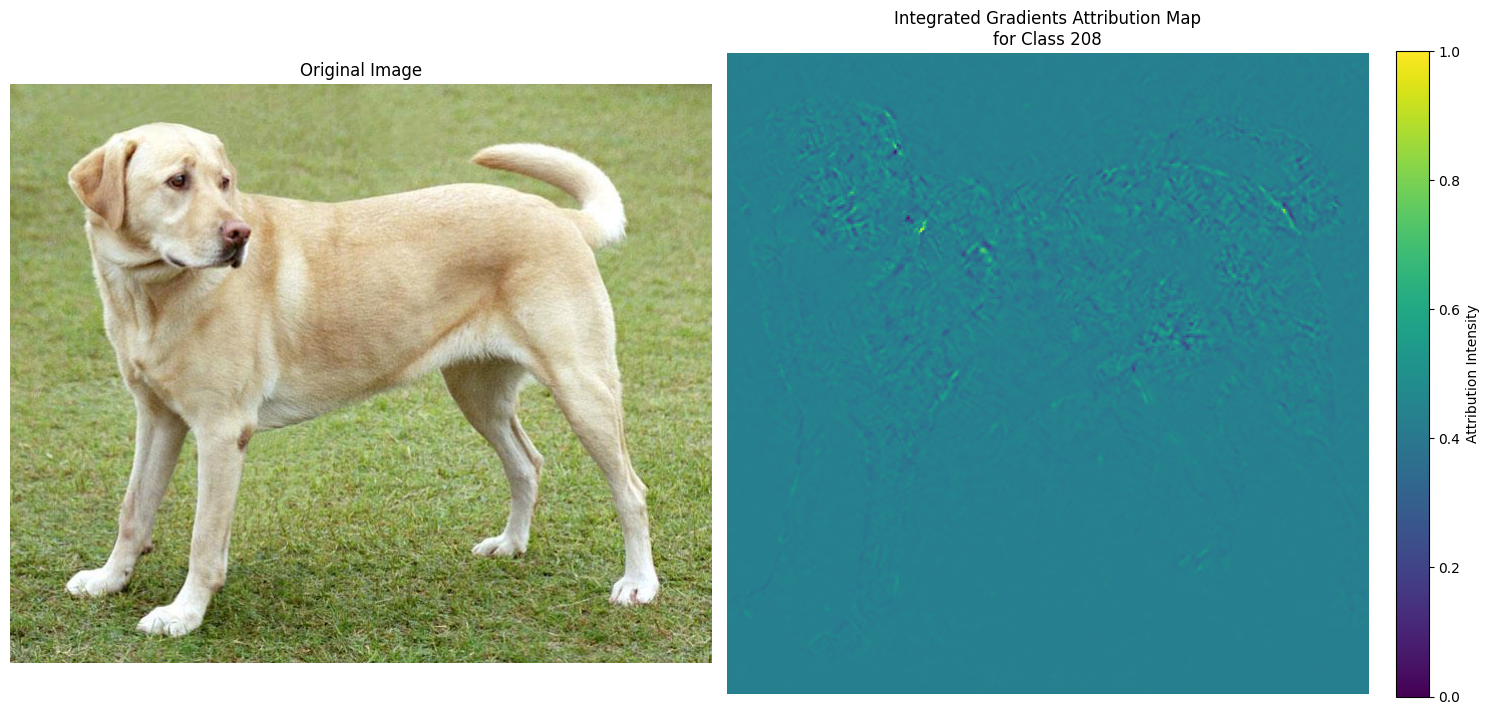

In [7]:
def run_and_visualize_ig(model, input_tensor, original_image, target_class):
    # Create a baseline (black image)
    baseline = torch.zeros_like(input_tensor).to(device)

    # Run Integrated Gradients
    attributions = integrated_gradients(model, input_tensor, target_class, baseline)

    # Sum attributions across color channels
    attribution_map = attributions.sum(dim=1).squeeze(0)

    # Normalize attributions for visualization
    attribution_map = (attribution_map - attribution_map.min()) / (attribution_map.max() - attribution_map.min())

    # Convert to numpy for visualization
    attribution_map = attribution_map.cpu().detach().numpy()

    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Original image
    ax1.imshow(original_image)
    ax1.set_title("Original Image")
    ax1.axis('off')

    # Attribution map
    im = ax2.imshow(attribution_map, cmap='viridis')
    ax2.set_title(f"Integrated Gradients Attribution Map\nfor Class {target_class}")
    ax2.axis('off')

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Attribution Intensity')

    plt.tight_layout()
    plt.show()

# Run the model to get the predicted class
with torch.no_grad():
    output = model(input_tensor)
predicted_class = output.argmax().item()

print(f"Predicted class: {predicted_class}")

# Get class labels
LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = requests.get(LABELS_URL)
labels = response.json()

print(f"Predicted class label: {labels[predicted_class]}")

# Run and visualize Integrated Gradients for the predicted class
run_and_visualize_ig(model, input_tensor, original_image, predicted_class)

In [8]:
import torch

def polynomial_interpolation(baseline, input, alpha, degree=3):
    """
    Perform polynomial-based non-linear interpolation between baseline and input.

    Args:
    baseline (torch.Tensor): The baseline input (usually zeros)
    input (torch.Tensor): The actual input to the model
    alpha (float): Interpolation parameter, varies from 0 to 1
    degree (int): Degree of the polynomial (default is 3 for cubic interpolation)

    Returns:
    torch.Tensor: Interpolated value between baseline and input
    """
    # Ensure alpha is a tensor
    if not isinstance(alpha, torch.Tensor):
        alpha = torch.tensor(alpha, device=input.device)

    # Compute polynomial factors
    factors = torch.pow(alpha.unsqueeze(0), torch.arange(1, degree + 1, device=alpha.device).float())

    # Compute interpolation factor
    interpolation_factor = factors.sum() / degree

    # Interpolate between baseline and input
    return baseline + (input - baseline) * interpolation_factor

# Example usage
baseline = torch.zeros(5)
input = torch.tensor([1, 2, 3, 4, 5])
alphas = torch.linspace(0, 1, 100)

interpolated_values = [polynomial_interpolation(baseline, input, alpha) for alpha in alphas]

print("Polynomial interpolation function defined.")

Polynomial interpolation function defined.


In [9]:
def integrated_gradients_polynomial(model, input, target_class, baseline, steps=50, polynomial_degree=3):
    model.zero_grad()

    # Generate alphas
    alphas = torch.linspace(0, 1, steps).to(device)

    # Accumulate gradients
    integrated_grads = torch.zeros_like(input).to(device)

    for alpha in alphas:
        # Generate interpolated inputs
        interpolated_input = polynomial_interpolation(baseline, input, alpha, degree=polynomial_degree)
        interpolated_input.requires_grad_(True)

        # Forward pass
        output = model(interpolated_input)

        # Backward pass
        model.zero_grad()
        output[0, target_class].backward()

        # Accumulate gradients
        integrated_grads += interpolated_input.grad

    # Average gradients and multiply by (input - baseline)
    integrated_grads *= (input - baseline) / steps

    return integrated_grads

print("Integrated Gradients function with polynomial interpolation implemented.")

Integrated Gradients function with polynomial interpolation implemented.


Predicted class: 208
Predicted class label: Labrador Retriever


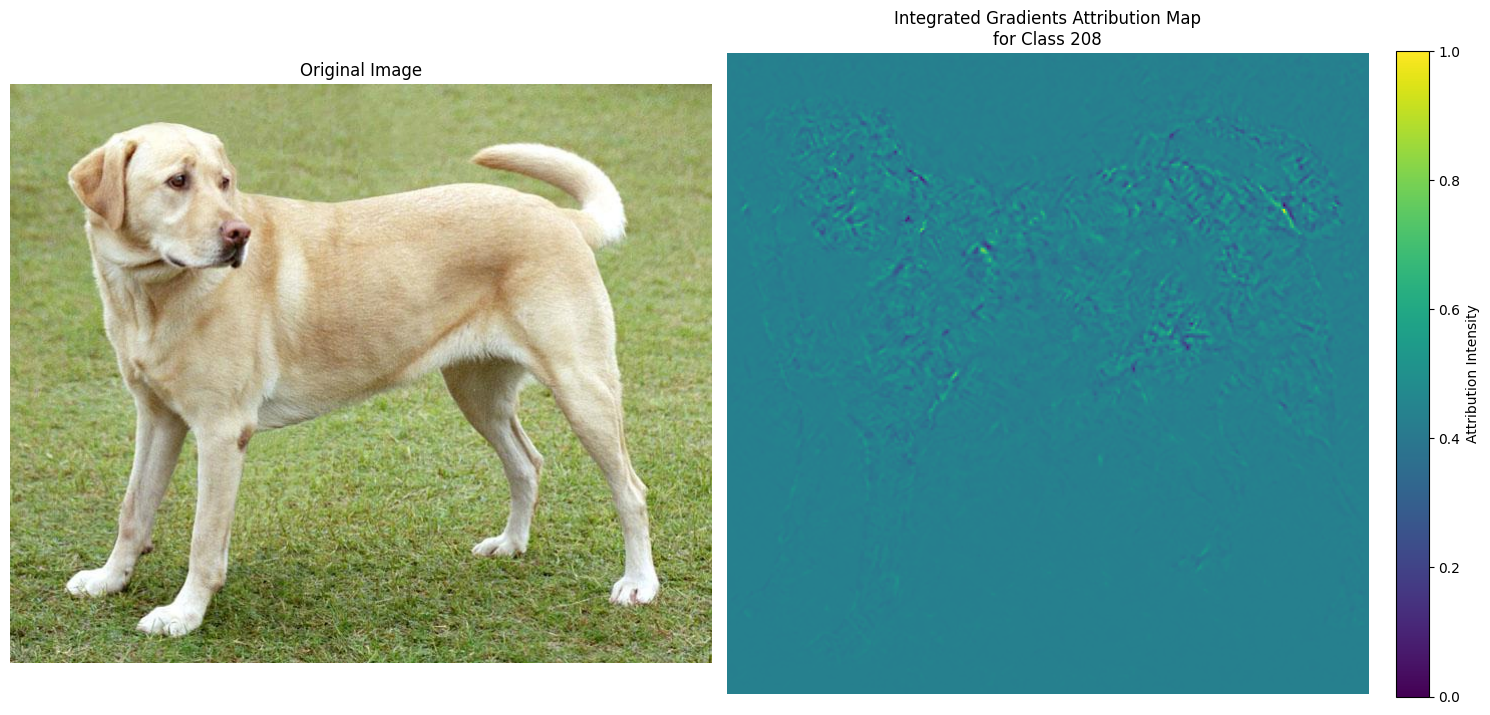

In [10]:
def run_and_visualize_ig(model, input_tensor, original_image, target_class):
    # Create a baseline (black image)
    baseline = torch.zeros_like(input_tensor).to(device)

    # Run Integrated Gradients
    attributions = integrated_gradients_polynomial(model, input_tensor, target_class, baseline)
    # Sum attributions across color channels
    attribution_map = attributions.sum(dim=1).squeeze(0)

    # Normalize attributions for visualization
    attribution_map = (attribution_map - attribution_map.min()) / (attribution_map.max() - attribution_map.min())

    # Convert to numpy for visualization
    attribution_map = attribution_map.cpu().detach().numpy()

    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Original image
    ax1.imshow(original_image)
    ax1.set_title("Original Image")
    ax1.axis('off')

    # Attribution map
    im = ax2.imshow(attribution_map, cmap='viridis')
    ax2.set_title(f"Integrated Gradients Attribution Map\nfor Class {target_class}")
    ax2.axis('off')

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Attribution Intensity')

    plt.tight_layout()
    plt.show()

# Run the model to get the predicted class
with torch.no_grad():
    output = model(input_tensor)
predicted_class = output.argmax().item()

print(f"Predicted class: {predicted_class}")

# Get class labels
LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = requests.get(LABELS_URL)
labels = response.json()

print(f"Predicted class label: {labels[predicted_class]}")

# Run and visualize Integrated Gradients for the predicted class
run_and_visualize_ig(model, input_tensor, original_image, predicted_class)

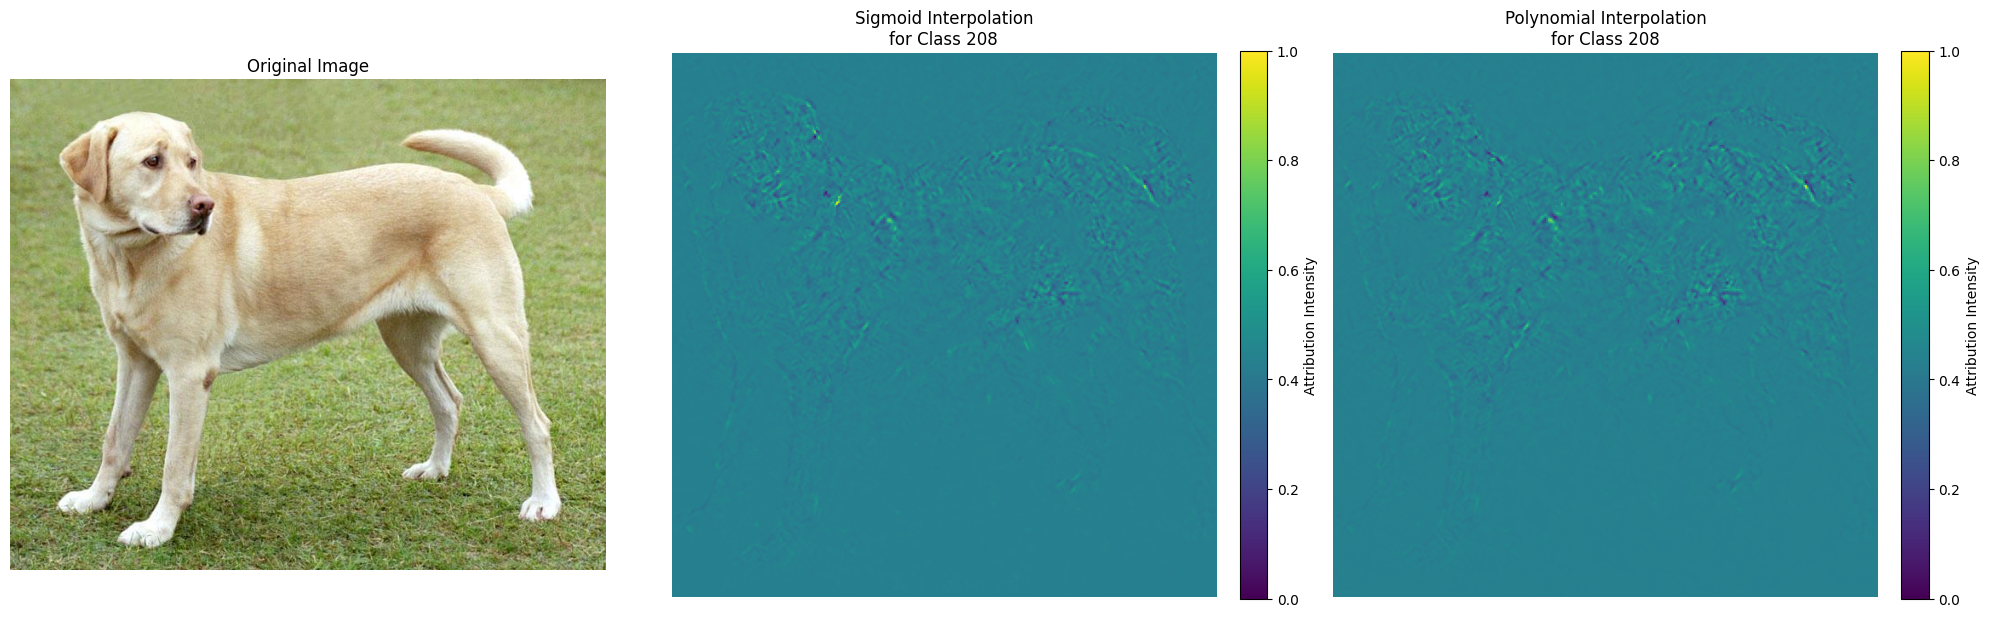

In [12]:

# Compare sigmoid and polynomial integrated gradients
def compare_integrated_gradients(model, input_tensor, target_class, baseline, steps=50, polynomial_degree=3):
    # Run Integrated Gradients with sigmoid interpolation
    attributions_sigmoid = integrated_gradients(model, input_tensor, target_class, baseline, steps)
    attribution_map_sigmoid = attributions_sigmoid.sum(dim=1).squeeze(0)
    attribution_map_sigmoid = (attribution_map_sigmoid - attribution_map_sigmoid.min()) / (attribution_map_sigmoid.max() - attribution_map_sigmoid.min())
    attribution_map_sigmoid = attribution_map_sigmoid.cpu().detach().numpy()

    # Run Integrated Gradients with polynomial interpolation
    attributions_polynomial = integrated_gradients_polynomial(model, input_tensor, target_class, baseline, steps, polynomial_degree)
    attribution_map_polynomial = attributions_polynomial.sum(dim=1).squeeze(0)
    attribution_map_polynomial = (attribution_map_polynomial - attribution_map_polynomial.min()) / (attribution_map_polynomial.max() - attribution_map_polynomial.min())
    attribution_map_polynomial = attribution_map_polynomial.cpu().detach().numpy()

    # Visualize
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

    # Original image
    ax1.imshow(original_image)
    ax1.set_title("Original Image")
    ax1.axis('off')

    # Sigmoid interpolation attribution map
    im1 = ax2.imshow(attribution_map_sigmoid, cmap='viridis')
    ax2.set_title(f"Sigmoid Interpolation\nfor Class {target_class}")
    ax2.axis('off')

    # Polynomial interpolation attribution map
    im2 = ax3.imshow(attribution_map_polynomial, cmap='viridis')
    ax3.set_title(f"Polynomial Interpolation\nfor Class {target_class}")
    ax3.axis('off')

    # Add colorbars
    cbar1 = fig.colorbar(im1, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
    cbar1.set_label('Attribution Intensity')
    cbar2 = fig.colorbar(im2, ax=ax3, orientation='vertical', fraction=0.046, pad=0.04)
    cbar2.set_label('Attribution Intensity')

    plt.tight_layout()
    plt.show()

# Compare the integrated gradients for the predicted class
baseline = torch.zeros_like(input_tensor).to(device)
compare_integrated_gradients(model, input_tensor, predicted_class, baseline)

In [13]:
# Compare the values of integrated gradients using sigmoid and polynomial interpolation
def compare_ig_values(model, input_tensor, target_class, baseline, steps=50, polynomial_degree=3):
    # Run Integrated Gradients with sigmoid interpolation
    attributions_sigmoid = integrated_gradients(model, input_tensor, target_class, baseline, steps)
    
    # Run Integrated Gradients with polynomial interpolation
    attributions_polynomial = integrated_gradients_polynomial(model, input_tensor, target_class, baseline, steps, polynomial_degree)
    
    # Compute the difference
    difference = attributions_sigmoid - attributions_polynomial
    
    # Print the differences
    print("Differences between sigmoid and polynomial integrated gradients:")
    print(difference)

# Compare the integrated gradients values for the predicted class
compare_ig_values(model, input_tensor, predicted_class, baseline)

Differences between sigmoid and polynomial integrated gradients:
tensor([[[[-1.1226e-05,  5.4314e-05, -6.9342e-05,  ..., -6.5194e-05,
            3.6443e-05,  3.2836e-05],
          [ 7.4345e-06, -3.1305e-05, -2.0387e-04,  ..., -2.3141e-05,
            1.0432e-06,  1.1983e-04],
          [-8.4905e-05, -2.4909e-06, -1.7896e-04,  ...,  1.0027e-04,
           -3.5296e-05, -4.7042e-05],
          ...,
          [ 1.4331e-06, -1.3449e-05,  1.1541e-07,  ...,  2.8978e-05,
            5.3587e-05,  3.6922e-05],
          [ 2.2820e-05, -2.7407e-05,  4.9969e-06,  ...,  2.9321e-06,
            6.3444e-06, -2.1490e-06],
          [ 1.1831e-05,  1.8076e-05,  1.3347e-05,  ...,  2.6665e-06,
            6.5032e-07,  2.2434e-06]],

         [[-3.8286e-05, -9.1581e-05, -3.0212e-04,  ..., -8.7516e-05,
           -1.0578e-04, -1.4710e-04],
          [-1.0997e-04, -4.7665e-04, -5.9058e-04,  ..., -4.1210e-05,
           -2.6078e-04, -3.0506e-05],
          [-3.0840e-04, -7.1655e-04, -5.9995e-04,  ...,  7.705

In [ ]:
def calculate_explainability(attribution_map, original_image):
    # Resize the original image to match the attribution map size
    original_image_resized = original_image.resize(attribution_map.shape[::-1], Image.BILINEAR)
    
    # Convert the original image to a numpy array and normalize it
    original_image_np = np.array(original_image_resized) / 255.0
    
    # Calculate the mean absolute difference
    explainability_score = np.mean(np.abs(attribution_map - original_image_np.mean(axis=2)))
    
    return explainability_score

# Calculate explainability for sigmoid interpolation
attributions_sigmoid = integrated_gradients(model, input_tensor, predicted_class, baseline)
attribution_map_sigmoid = attributions_sigmoid.sum(dim=1).squeeze(0)
attribution_map_sigmoid = (attribution_map_sigmoid - attribution_map_sigmoid.min()) / (attribution_map_sigmoid.max() - attribution_map_sigmoid.min())
attribution_map_sigmoid = attribution_map_sigmoid.cpu().detach().numpy()
explainability_sigmoid = calculate_explainability(attribution_map_sigmoid, original_image)

# Calculate explainability for polynomial interpolation
attributions_polynomial = integrated_gradients_polynomial(model, input_tensor, predicted_class, baseline)
attribution_map_polynomial = attributions_polynomial.sum(dim=1).squeeze(0)
attribution_map_polynomial = (attribution_map_polynomial - attribution_map_polynomial.min()) / (attribution_map_polynomial.max() - attribution_map_polynomial.min())
attribution_map_polynomial = attribution_map_polynomial.cpu().detach().numpy()
explainability_polynomial = calculate_explainability(attribution_map_polynomial, original_image)

print(f"Explainability score for sigmoid interpolation: {explainability_sigmoid}")
print(f"Explainability score for polynomial interpolation: {explainability_polynomial}")

if explainability_sigmoid < explainability_polynomial:
    print("Sigmoid interpolation provides more explainability.")
else:
    print("Polynomial interpolation provides more explainability.")

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load a pre-trained model (e.g., ResNet) and set to evaluation mode
model = models.resnet50(pretrained=True)
model.eval()


# Image preprocessing function (standard for ImageNet models)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to load and preprocess an image
def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

# Integrated Gradients with Non-Linear Interpolation
def integrated_gradients(model, input_tensor, baseline, target_label_idx, steps=50, interpolation_fn='linear'):
    input_tensor.requires_grad = True
    baseline = baseline.to(input_tensor.device)
    
    # Define different interpolation functions
    if interpolation_fn == 'linear':
        alphas = np.linspace(0, 1, steps)
    elif interpolation_fn == 'quadratic':
        alphas = np.linspace(0, 1, steps)**2  # Quadratic interpolation
    elif interpolation_fn == 'exponential':
        alphas = np.exp(np.linspace(0, 1, steps)) - 1  # Exponential interpolation
    elif interpolation_fn == 'logarithmic':
        alphas = np.log(np.linspace(1, 2, steps))  # Logarithmic interpolation
    
    # Make sure alphas is a tensor
    alphas = torch.tensor(alphas).float().to(input_tensor.device)

    # Initialize the total gradients
    total_gradients = torch.zeros_like(input_tensor).to(input_tensor.device)
    
    for alpha in alphas:
        # Interpolated input
        interpolated_input = baseline + alpha * (input_tensor - baseline)
        
        # Forward pass
        model_output = model(interpolated_input)
        
        # Select the target label (index) to compute gradients
        target = model_output[:, target_label_idx].sum()

        # Backward pass
        grads = torch.autograd.grad(outputs=target, inputs=interpolated_input, create_graph=True)[0]
        
        total_gradients += grads
    
    # Average gradients and multiply by the difference between input and baseline
    avg_gradients = total_gradients / steps
    attributions = (input_tensor - baseline) * avg_gradients
    
    return attributions

# Function to visualize attributions
def visualize_attributions(attributions, title):
    attributions = attributions.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    attributions = np.mean(attributions, axis=2)  # Average across color channels
    attributions = np.maximum(attributions, 0)  # ReLU to remove negative attributions
    plt.imshow(attributions, cmap='hot')
    plt.title(title)
    plt.colorbar()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Load and preprocess the image
    image_path = 'image.JPG'  # Replace with your image path
    input_tensor = load_image(image_path)
    baseline = torch.zeros_like(input_tensor)  # Baseline (black image)
    
    # Forward pass to get predicted label
    output = model(input_tensor)
    target_label_idx = output.argmax(dim=1).item()  # Predicted label index
    
    # Compute attributions for different interpolation functions
    attributions_linear = integrated_gradients(model, input_tensor, baseline, target_label_idx, interpolation_fn='linear')
    attributions_quadratic = integrated_gradients(model, input_tensor, baseline, target_label_idx, interpolation_fn='quadratic')
    attributions_exponential = integrated_gradients(model, input_tensor, baseline, target_label_idx, interpolation_fn='exponential')
    attributions_logarithmic = integrated_gradients(model, input_tensor, baseline, target_label_idx, interpolation_fn='logarithmic')
    
    # Visualize the attributions
    visualize_attributions(attributions_linear, "Linear Interpolation Attributions")
    visualize_attributions(attributions_quadratic, "Quadratic Interpolation Attributions")
    visualize_attributions(attributions_exponential, "Exponential Interpolation Attributions")
    visualize_attributions(attributions_logarithmic, "Logarithmic Interpolation Attributions")


C:\Users\shawn\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
